# Clustering


In [2]:
import glob

import matplotlib.pyplot as plt
import numpy as np
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
import sys
sys.path.append(os.path.abspath('/Volumes/T7/Voxel_Bank/Code/Software/CarDpy-master'))
from cardpy.Sample_Data.Data_Paths import *
from cardpy.Data_Import            import *
from cardpy.Data_Sorting           import *
from cardpy.Data_Processing.DTI    import *
from cardpy.GUI_Tools              import IntERCOMS
from cardpy.Colormaps              import *
from cardpy.Data_Saving            import *
from cardpy.Data_Processing.cDTI   import *
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import nrrd
import sys

cDTI_cmaps     = cDTI_Colormaps_Generator()


import seaborn as sns
sns.set(style='darkgrid', palette='Set2')

from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


# Helper Functions

In [3]:
sys.path.append(os.path.abspath('../../Code/Software/'))
def myocardial_mask_contour_filler(myocardial_mask, endocardial_cordinates, epicardial_cordinates):
    import cv2
    import numpy as np
    from cDTIpy.Diffusion.cDTI import point2pixel
    
    new_endocardial_x   = []
    new_endocardial_y   = []
    new_epicardial_x    = []
    new_epicardial_y    = []
    rows                = myocardial_mask.shape[0]
    columns             = myocardial_mask.shape[1]
    endocardial_contour = np.zeros([rows, columns])
    for index in range(endocardial_cordinates[0].shape[0]):
        [new_x_coordinate, new_y_coordinate] = point2pixel(epicardial_cordinates[0][index],  epicardial_cordinates[1][index])
        new_epicardial_x.append(new_x_coordinate)
        new_epicardial_y.append(new_y_coordinate)
        [new_x_coordinate, new_y_coordinate] = point2pixel(endocardial_cordinates[0][index], endocardial_cordinates[1][index])
        new_endocardial_x.append(new_x_coordinate)
        new_endocardial_y.append(new_y_coordinate)

    new_endocardium_points = [np.array(new_endocardial_x), np.array(new_endocardial_y)]
    new_epicardium_points  = [np.array(new_epicardial_x),  np.array(new_epicardial_y)]

    endocardial_points = np.hstack((new_endocardium_points[0][:, np.newaxis], new_endocardium_points[1][:, np.newaxis]))
    epicardial_points  = np.hstack((new_epicardium_points[0][:, np.newaxis],  new_epicardium_points[1][:, np.newaxis]))
    temp_matrix        = np.zeros([rows, columns])
    endocardial_mask   = cv2.fillPoly(temp_matrix, np.int32([endocardial_points]), color=(255,255,255))
    endocardial_mask   = endocardial_mask / 255
    temp_matrix        = np.zeros([rows, columns])
    epicardial_mask    = cv2.fillPoly(temp_matrix, np.int32([epicardial_points]),  color=(255,255,255))
    epicardial_mask    = epicardial_mask / 255
    
    for index in range(endocardial_points.shape[0]):
        x                         = endocardial_points[index, 0]
        y                         = endocardial_points[index, 1]
        endocardial_contour[y, x] = 1
    filled_myocardial_mask = epicardial_mask - endocardial_mask + endocardial_contour
    return filled_myocardial_mask

def point2pixel(x_coordinate, y_coordinate):
    import numpy as np
    import math
    point_x = x_coordinate
    point_y = y_coordinate
    
    floor_x = np.floor(point_x)
    floor_y = np.floor(point_y)
    ceil_x  = np.ceil(point_x)
    ceil_y  = np.ceil(point_y)
    
    point  = np.array([point_x, point_y])
    quad_1 = np.array([ceil_x,  floor_y])
    quad_2 = np.array([ceil_x,  ceil_y])
    quad_3 = np.array([floor_x, ceil_y])
    quad_4 = np.array([floor_x, floor_y])
    
    quadrant_list = [np.array([ceil_x,  floor_y]), np.array([ceil_x,  ceil_y]), np.array([floor_x, ceil_y]), np.array([floor_x, floor_y])]
    distance_list = []
    for quadrant in range(len(quadrant_list)):
        distance_list.append(math.dist(point, quadrant_list[quadrant]))
    
    quadrant_index = distance_list.index(min(distance_list))
    new_x_coordinate = int(quadrant_list[quadrant_index][0])
    new_y_coordinate = int(quadrant_list[quadrant_index][1])
    return[new_x_coordinate, new_y_coordinate]
    
def myocardial_contour_extraction(mask, slice_number):
    import numpy as np
    import skimage
    from   cDTIpy.Diffusion.cDTI import comprehensive_inner_contour, comprehensive_outter_contour

    rows = mask.shape[0]
    cols = mask.shape[1]
    slc  = slice_number
    Background_Mask = np.zeros([rows, cols])
    Myocardial_Mask = np.zeros([rows, cols])
    Blood_Pool_Mask = np.zeros([rows, cols])
    Endocardial_Centers  = []
    Epicardium_Contours  = []
    Endocardium_Contours = []
    Background_temp = np .zeros([rows, cols])
    Myocardium_temp = np .zeros([rows, cols])
    Blood_Pool_temp = np .zeros([rows, cols])
    Mask_Label = skimage.measure.label(abs(mask[:, :, slc] - 1),
                                       background = None,
                                       return_num = False,
                                       connectivity = 1)
     
    Background_temp[Mask_Label == 1] = 1
    Myocardium_temp[Mask_Label == 0] = 1
    Blood_Pool_temp[Mask_Label == 2] = 1
    
    Background_Mask = Background_temp
    Myocardial_Mask = Myocardium_temp
    Blood_Pool_Mask = Blood_Pool_temp
    
    [x_coordinates_endo,  y_coordinates_endo] = np.where(Blood_Pool_temp == 1)
    mean_y_coordinates_endo  = np.int64(np.round(np.mean(y_coordinates_endo)))
    mean_x_coordinates_endo  = np.int64(np.round(np.mean(x_coordinates_endo)))
    Endocardial_Centers.append([mean_x_coordinates_endo, mean_y_coordinates_endo])
    
    epicardium_contour  = comprehensive_outter_contour(Myocardial_Mask)
    endocardium_contour = comprehensive_inner_contour(Myocardial_Mask,
                                                      np.int64(Endocardial_Centers[0][0]),
                                                      np.int64(Endocardial_Centers[0][1]))
    endocardium_contour = endocardium_contour - (endocardium_contour * epicardium_contour)
    Epicardium_Contours.append(epicardium_contour)
    Endocardium_Contours.append(endocardium_contour)
    
    return [Epicardium_Contours, Endocardium_Contours, Endocardial_Centers]
    
def comprehensive_inner_contour(mask, offset_x, offset_y):
    import numpy as np
    rows = mask.shape[0]
    cols = mask.shape[1]

    pos_x_pos_y = np.zeros([rows, cols])
    pos_x_pos_y = np.zeros([rows, cols])
    for x in range(rows - offset_x):
        stop_flag = 'OFF'
        if mask[x + offset_x, 0 + offset_y] == 1:
            stop_flag = 'ON'
        for y in range(cols - offset_y):
            if stop_flag == 'OFF':
                if mask[x + offset_x, y + offset_y] == 0:
                    pos_x_pos_y[x + offset_x, y + offset_y] = 0
                if mask[x + offset_x, y + offset_y] == 1:
                    pos_x_pos_y[x + offset_x, y + offset_y] = 1
                    stop_flag = 'ON'
            if stop_flag == 'ON':
                break
    pos_x_neg_y = np.zeros([rows, cols])
    for x in range(rows - offset_x):
        stop_flag = 'OFF'
        if mask[x + offset_x, offset_y - 0] == 1:
            stop_flag = 'ON'
        for y in range(offset_y + 1):
            if stop_flag == 'OFF':
                if mask[x + offset_x, offset_y - y] == 0:
                    pos_x_neg_y[x + offset_x, offset_y - y] = 0
                if mask[x + offset_x, offset_y - y] == 1:
                    pos_x_neg_y[x + offset_x, offset_y - y] = 1
                    stop_flag = 'ON'
            if stop_flag == 'ON':
                break
    neg_x_neg_y = np.zeros([rows, cols])
    for x in range(offset_x + 1):
        stop_flag = 'OFF'
        if mask[offset_x - x, offset_y - 0] == 1:
            stop_flag = 'ON'
        for y in range(offset_y + 1):
            if stop_flag == 'OFF':
                if mask[offset_x - x, offset_y - y] == 0:
                    neg_x_neg_y[offset_x - x, offset_y - y] = 0
                if mask[offset_x - x, offset_y - y] == 1:
                    neg_x_neg_y[offset_x - x, offset_y - y] = 1
                    stop_flag = 'ON'
            if stop_flag == 'ON':
                break
    neg_x_pos_y = np.zeros([rows, cols])
    for x in range(offset_x + 1):
        stop_flag = 'OFF'
        if mask[offset_x - x, 0 + offset_y] == 1:
            stop_flag = 'ON'
        for y in range(cols - offset_y):
            if stop_flag == 'OFF':
                if mask[offset_x - x, y + offset_y] == 0:
                    neg_x_pos_y[offset_x - x, y + offset_y] = 0
                if mask[offset_x - x, y + offset_y] == 1:
                    neg_x_pos_y[offset_x - x, y + offset_y] = 1
                    stop_flag = 'ON'
            if stop_flag == 'ON':
                break
    ###
    pos_y_pos_x = np.zeros([rows, cols])
    for y in range(cols - offset_y):
        stop_flag = 'OFF'
        if mask[0 + offset_x, y + offset_y] == 1:
            stop_flag = 'ON'
        for x in range(rows - offset_x):
            if stop_flag == 'OFF':
                if mask[x + offset_x, y + offset_y] == 0:
                    pos_y_pos_x[x + offset_x, y + offset_y] = 0
                if mask[x + offset_x, y + offset_y] == 1:
                    pos_y_pos_x[x + offset_x, y + offset_y] = 1
                    stop_flag = 'ON'
            if stop_flag == 'ON':
                break
    neg_y_pos_x = np.zeros([rows, cols])
    for y in range(offset_y + 1):
        stop_flag = 'OFF'
        if mask[0 + offset_x, offset_y - y] == 1:
            stop_flag = 'ON'
        for x in range(rows - offset_x):
            if stop_flag == 'OFF':
                if mask[x + offset_x, offset_y - y] == 0:
                    neg_y_pos_x[x + offset_x, offset_y - y] = 0
                if mask[x + offset_x, offset_y - y] == 1:
                    neg_y_pos_x[x + offset_x, offset_y - y] = 1
                    stop_flag = 'ON'
            if stop_flag == 'ON':
                break
    neg_y_neg_x = np.zeros([rows, cols])
    for y in range(offset_y + 1):
        stop_flag = 'OFF'
        if mask[offset_x - 0, offset_y - y] == 1:
            stop_flag = 'ON'
        for x in range(offset_x + 1):
            if stop_flag == 'OFF':
                if mask[offset_x - x, offset_y - y] == 0:
                    neg_y_neg_x[offset_x - x, offset_y - y] = 0
                if mask[offset_x - x, offset_y - y] == 1:
                    neg_y_neg_x[offset_x - x, offset_y - y] = 1
                    stop_flag = 'ON'
            if stop_flag == 'ON':
                break
    pos_y_neg_x = np.zeros([rows, cols])
    for y in range(cols - offset_y):
        stop_flag = 'OFF'
        if mask[offset_x - 0, y + offset_y] == 1:
            stop_flag = 'ON'
        for x in range(offset_x + 1):
            if stop_flag == 'OFF':
                if mask[offset_x - x, y + offset_y] == 0:
                    pos_y_neg_x[offset_x - x, y + offset_y] = 0
                if mask[offset_x - x, y + offset_y] == 1:
                    pos_y_neg_x[offset_x - x, y + offset_y] = 1
                    stop_flag = 'ON'
            if stop_flag == 'ON':
                break

    x_all = pos_x_pos_y + pos_x_neg_y + neg_x_neg_y + neg_x_pos_y
    y_all = pos_y_pos_x + pos_y_neg_x + neg_y_neg_x + neg_y_pos_x
    contour = x_all + y_all
    contour[contour >= 1] = 1
    return contour

def comprehensive_outter_contour(mask):
    import numpy as np

    rows = mask.shape[0]
    cols = mask.shape[1]

    pos_x_pos_y = np.zeros([rows, cols])
    for x in range(rows):
        stop_flag = 'OFF'
        for y in range(cols):
            if stop_flag == 'OFF':
                if mask[x, y] == 0:
                    pos_x_pos_y[x, y] = 0
                if mask[x, y] == 1:
                    pos_x_pos_y[x, y] = 1
                    stop_flag = 'ON'
            if stop_flag == 'ON':
                break
    pos_x_neg_y = np.zeros([rows, cols])
    for x in range(rows):
        stop_flag = 'OFF'
        for y in range(cols):
            if stop_flag == 'OFF':
                if mask[x, cols - 1 - y] == 0:
                    pos_x_pos_y[x, cols - 1 - y] = 0
                if mask[x, cols - 1 - y] == 1:
                    pos_x_pos_y[x, cols - 1 - y] = 1
                    stop_flag = 'ON'
            if stop_flag == 'ON':
                break
    neg_x_neg_y = np.zeros([rows, cols])
    for x in range(rows):
        stop_flag = 'OFF'
        for y in range(cols):
            if stop_flag == 'OFF':
                if mask[rows - 1 - x, cols - 1 - y] == 0:
                    pos_x_pos_y[rows - 1 - x, cols - 1 - y] = 0
                if mask[rows - 1 - x, cols - 1 - y] == 1:
                    pos_x_pos_y[rows - 1 - x, cols - 1 - y] = 1
                    stop_flag = 'ON'
            if stop_flag == 'ON':
                break
    neg_x_pos_y = np.zeros([rows, cols])
    for x in range(rows):
        stop_flag = 'OFF'
        for y in range(cols):
            if stop_flag == 'OFF':
                if mask[rows - 1 - x, y] == 0:
                    pos_x_pos_y[rows - 1 - x, y] = 0
                if mask[rows - 1 - x, y] == 1:
                    pos_x_pos_y[rows - 1 - x, y] = 1
                    stop_flag = 'ON'
            if stop_flag == 'ON':
                break
    ###
    pos_y_pos_x = np.zeros([rows, cols])
    for y in range(cols):
        stop_flag = 'OFF'
        for x in range(rows):
            if stop_flag == 'OFF':
                if mask[x, y] == 0:
                    pos_y_pos_x[x, y] = 0
                if mask[x, y] == 1:
                    pos_y_pos_x[x, y] = 1
                    stop_flag = 'ON'
            if stop_flag == 'ON':
                break
    pos_y_neg_x = np.zeros([rows, cols])
    for y in range(cols):
        stop_flag = 'OFF'
        for x in range(rows):
            if stop_flag == 'OFF':
                if mask[rows - 1 - x, y] == 0:
                    pos_y_neg_x[rows - 1 - x, y] = 0
                if mask[rows - 1 - x, y] == 1:
                    pos_y_neg_x[rows - 1 - x, y] = 1
                    stop_flag = 'ON'
            if stop_flag == 'ON':
                break
    neg_y_neg_x = np.zeros([rows, cols])
    for y in range(cols):
        stop_flag = 'OFF'
        for x in range(rows):
            if stop_flag == 'OFF':
                if mask[rows - 1 - x, cols - 1 - y] == 0:
                    neg_y_neg_x[rows - 1 - x, cols - 1 - y] = 0
                if mask[rows - 1 - x, cols - 1 - y] == 1:
                    neg_y_neg_x[rows - 1 - x, cols - 1 - y] = 1
                    stop_flag = 'ON'
            if stop_flag == 'ON':
                break
    neg_y_pos_x = np.zeros([rows, cols])
    for y in range(cols):
        stop_flag = 'OFF'
        for x in range(rows):
            if stop_flag == 'OFF':
                if mask[x, cols - 1 - y] == 0:
                    neg_y_pos_x[x, cols - 1 - y] = 0
                if mask[x, cols - 1 - y] == 1:
                    neg_y_pos_x[x, cols - 1 - y] = 1
                    stop_flag = 'ON'
            if stop_flag == 'ON':
                break
    x_all = pos_x_pos_y + pos_x_neg_y + neg_x_neg_y + neg_x_pos_y
    y_all = pos_y_pos_x + pos_y_neg_x + neg_y_neg_x + neg_y_pos_x
    contour = x_all + y_all
    contour[contour >= 1] = 1
    return contour


In [4]:
def Endo2Epi_grid(LV_Mask):
    import skimage
    import numpy as np
    from scipy.interpolate import griddata

    rows    = LV_Mask.shape[0]
    columns = LV_Mask.shape[1]
    slices  = LV_Mask.shape[2]
    grid    = np.zeros([rows, columns, slices])

    for slc in range(slices):

        tmp_mask = np.ones([rows, columns]) - LV_Mask[:, :, slc]
        labels = skimage.measure.label(tmp_mask, connectivity = 1, background = 0, return_num = True)

        Epi_Outside = np.zeros([rows, columns])
        Endo_inside = np.zeros([rows, columns])

        Epi_Outside[labels[0] == 1] = 1
        Endo_inside[labels[0] == 2] = 1

        [epi_x,  epi_y]             = np.where(Epi_Outside == 1)
        [endo_x, endo_y]            = np.where(Endo_inside == 1)
        epi  = np.stack((epi_y, epi_x), axis=1)
        endo  = np.stack((endo_y, endo_x), axis=1)
        points = np.vstack((epi,endo))

        epi_val  = np.ones((epi_x.shape[0], 1))
        endo_val = np.zeros((endo_x.shape[0], 1))    
        values   = np.vstack((epi_val,endo_val))

        x = np.linspace(0, rows - 1,    rows)
        y = np.linspace(0, columns - 1, columns)
        xi, yi = np.meshgrid(y, x)
        tmp_grid = np.squeeze(griddata(points, values, (xi, yi), method='cubic')) * LV_Mask[:, :, slc]
        grid[:, :, slc] = tmp_grid
    return grid

# One Excel Sheet of the Medians and Means from all volunteers

In [5]:
vox_folder = ['vol_2.0res_3.0sl','vol_2.0res_5.0sl','vol_2.0res_8.0sl',
            'vol_2.5res_3.0sl','vol_2.5res_5.0sl','vol_2.5res_8.0sl',
            'vol_3.0res_3.5sl','vol_3.0res_5.5sl','vol_3.0res_8.0sl']
            
vol_idx = ['V001','V002','V003','V004','V005','V006','V007','V008','V009','V010', 'V011']
volumes = [2*2*3,2*2*5,2*2*8,2.5*2.5*3,2.5*2.5*5,2.5*2.5*8,3*3*3.5,3*3*5.5,3*3*8]


/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_12576/126795072.py:44: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_12576/126795072.py:44: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_12576/126795072.py:44: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_12576/126795072.py:44: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_12576/126795072.py:44: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype('int')
/var/folders/mb/68q17fnn0sbfmdht6h_p8mlw0000gn/T/ipykernel_12576/126795072.py:44: RuntimeWarning: invalid value encountered in cast
  tmp_mask = tmp_mask.astype

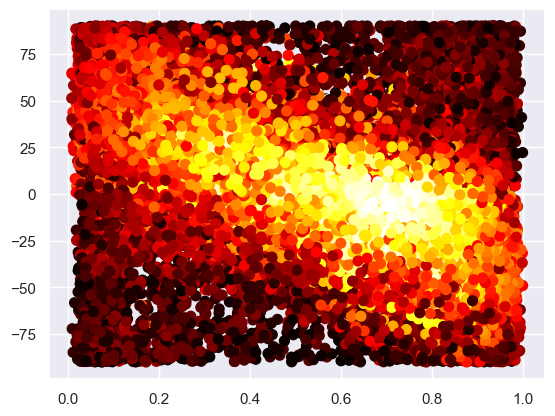

In [6]:
# Load in Volunteer Data
tot_volunteers = 11

# Initialize empty dataframes for median. This list will be converted to the dataframe
FA =np.zeros((tot_volunteers,9))
median = pd.DataFrame({})
df = pd.DataFrame({})
uncertainty = pd.DataFrame({})

for vv in range(0,tot_volunteers):
    max_likelihood = []
    for ii in range(9):
        main_path = os.path.join(os.path.abspath('../../Data/NifTi/'+vol_idx[vv]) + '/'+ vox_folder[ii] + '/ADC_Filtered')
        path_segmentation = os.path.join(os.path.abspath('../../Data/Segmentations/'+vol_idx[vv]),vox_folder[ii])
        path_maps  = os.path.join(os.path.abspath('../../Data/DTI_Maps/'+vol_idx[vv])+'/'+ vox_folder[ii] + '/ADC_Filtered')
        path_uncertainties =  os.path.join(os.path.abspath('../../Data/Uncertainty_Maps/'+vol_idx[vv])+'/'+ vox_folder[ii] )

        NifTi_path = glob.glob(os.path.join(main_path, '*Averaged', '*.nii'))[0]
        header_path              = glob.glob(os.path.join(main_path, '*Averaged', '*.header'))[0]
        b_values_path            = glob.glob(os.path.join(main_path, '*Averaged', '*.bvals'))[0]
        b_vectors_path           = glob.glob(os.path.join(main_path, '*Averaged', '*.bvecs'))[0]


        Seg_path    = os.path.join(path_segmentation)
        Maps_Folder = os.path.join(path_maps)
        Uncertainties_Folder = os.path.join(path_uncertainties)

        
        [data, b_vals_stacked, b_vecs_stacked, Header, _, _] = NifTi_Reader(NifTi_path, b_values_path, b_vectors_path, header_path)
        myo_mask = loadmat(os.path.join(Seg_path,'Interpolated_mask.mat'))['Mask']
        myo_mask = myo_mask.astype('float')
        myo_mask[myo_mask == 0] = np.nan

        dim_x = data.shape[0]
        dim_y = data.shape[1]

        Standard_DTI_Metrics = loadmat(os.path.join(Maps_Folder, 'Standard_DTI_Metrics.mat'))
        Invariant_Uncertainties = loadmat(os.path.join(Uncertainties_Folder, 'Invariant_Uncertainties.mat'))
        Cardiac_DTI_Metrics = loadmat(os.path.join(Maps_Folder, 'cDTI_Metrics.mat'))
        Vector_Uncertainties = loadmat(os.path.join(Uncertainties_Folder, 'Vector_Uncertainties.mat'))
  
        slc = 0
        tmp_mask = myo_mask
        tmp_mask = tmp_mask.astype('int')
        grid = Endo2Epi_grid(tmp_mask)
        grid_nan = np.copy(grid)
        grid_nan[grid == 0] = np.nan

        E2E_data = grid_nan[:, :, slc].flatten()
        E2E_map = grid_nan[:, :, slc]
        E2E_data = E2E_data[~(np.isnan(grid_nan[:, :, slc].flatten()))]
        x = E2E_data
        xi = np.copy(x)

        HA = Cardiac_DTI_Metrics['HA'][:, :, 0]
        HA_data  = HA.flatten()
        HA_data  = HA_data[~(np.isnan(grid_nan[:, :, 0].flatten()))]
        y = HA_data
        # remove nan from y numpy array
        idx = np.argwhere(np.isnan(y))
        y = y[~np.isnan(y)]
        yi = np.copy(y)

        # delete nan from x numpy array
        x = np.delete(x, idx)
        
        # Calculate the point density
        xy = np.vstack([x, y])

        z = gaussian_kde(xy)(xy)

        # Sort the points by density, so that the densest points are plotted last
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
        density = plt.scatter(x, y, c=z, s=50, cmap = 'hot')
        model                 = LinearRegression().fit(x[:, np.newaxis], y[:, np.newaxis])
        HAP   = model.coef_[0][0] / 100

        
        median = pd.concat([median, pd.DataFrame({
                #'Voxel':float(volumes[ii]),
                #'Inplane':vox_folder[ii].split('_')[1],
                'Volunteer':[vol_idx[ii]],
                'Resolution':vox_folder[ii],
                'FA':np.nanmean(np.squeeze(Standard_DTI_Metrics['FA']*myo_mask),axis = (0,1)),
                'MD':np.nanmean(np.squeeze(Standard_DTI_Metrics['MD']*myo_mask),axis = (0,1)),
                'HAP': HAP,
                'dFA':np.nanmedian(np.squeeze(Invariant_Uncertainties['dFA']*myo_mask),axis = (0,1)),
                'dMD':np.nanmedian(np.squeeze(Invariant_Uncertainties['dMD']*myo_mask),axis = (0,1)),
                'dE1':np.nanmedian(np.squeeze(Vector_Uncertainties['dE1']*myo_mask),axis = (0,1)),
                })],
                ignore_index=True)
        
    


In [7]:
# save in excel
median.to_excel('All_Data.xlsx')

# Grouping and Ranking

In [8]:
median_per_resolution = median.groupby('Resolution').agg({
    #'Voxel': 'median',
    'FA': 'median',
    'MD': 'median',
    'HAP': 'median',
    'dFA': 'median',
    'dMD': 'median',
    'dE1': 'median',
    'Volunteer': lambda x: list(x)  # Store as a list, or use x.mode()[0] to keep the most common
}).reset_index()

# save in excel
median.to_excel('Median_Values.xlsx')


In [9]:
median_per_resolution

,Resolution,FA,MD,HAP,dFA,dMD,dE1,Volunteer
0,vol_2.0res_3.0sl,0.301745,1.352362,-0.579140,0.253005,0.635887,28.008035,"[V001, V001, V001, V001, V001, V001, V001, V00..."
1,vol_2.0res_5.0sl,0.311438,1.455240,-0.565260,0.198458,0.534790,22.200369,"[V002, V002, V002, V002, V002, V002, V002, V00..."
2,vol_2.0res_8.0sl,0.356504,1.435610,-0.673603,0.195128,0.487526,16.855096,"[V003, V003, V003, V003, V003, V003, V003, V00..."
3,vol_2.5res_3.0sl,0.268118,1.576443,-0.509308,0.205807,0.614236,26.634183,"[V004, V004, V004, V004, V004, V004, V004, V00..."
4,vol_2.5res_5.0sl,0.279878,1.689772,-0.707029,0.178029,0.513874,19.953093,"[V005, V005, V005, V005, V005, V005, V005, V00..."
5,vol_2.5res_8.0sl,0.312533,1.643868,-0.645457,0.169522,0.480404,18.656678,"[V006, V006, V006, V006, V006, V006, V006, V00..."
6,vol_3.0res_3.5sl,0.241060,1.737499,-0.563859,0.198801,0.577611,33.703019,"[V007, V007, V007, V007, V007, V007, V007, V00..."
7,vol_3.0res_5.5sl,0.245580,1.891127,-0.682426,0.175400,0.553489,28.211040,"[V008, V008, V008, V008, V008, V008, V008, V00..."
8,vol_3.0res_8.0sl,0.251524,1.911194,-0.515264,0.163918,0.516888,24.118381,"[V009, V009, V009, V009, V009, V009, V009, V00..."


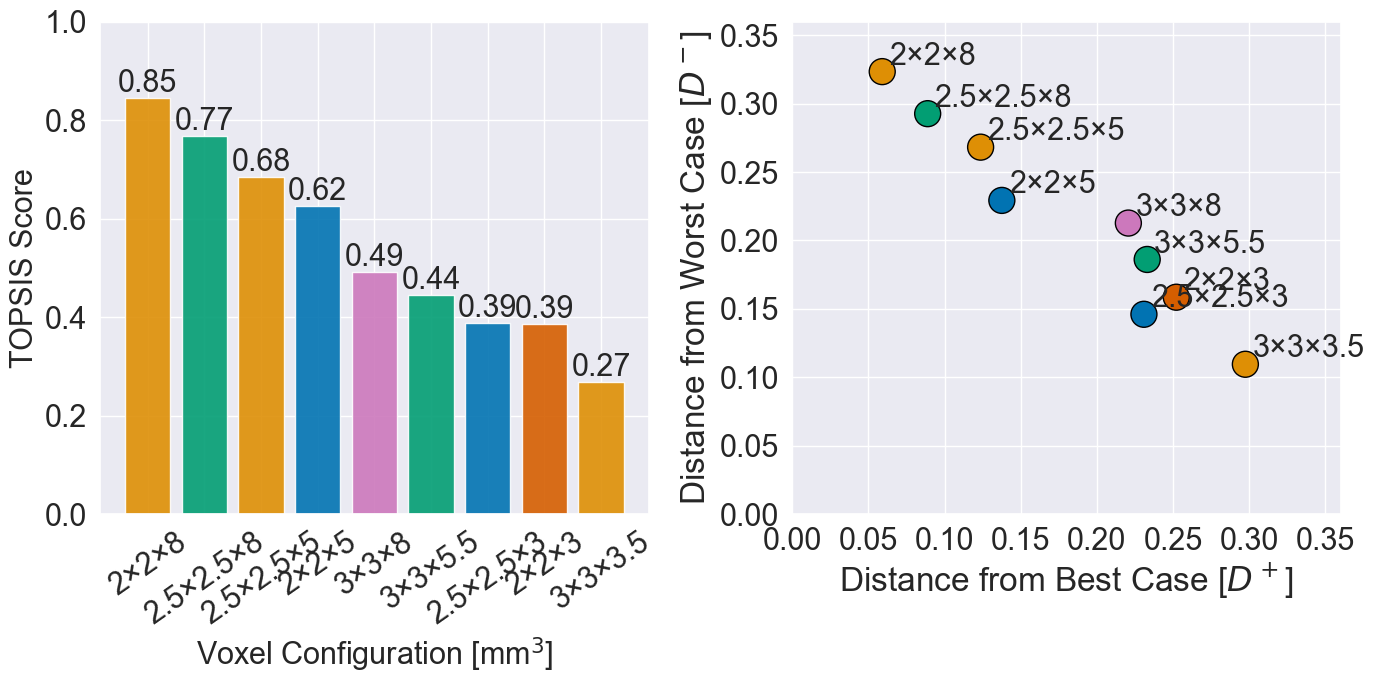

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

df = median_per_resolution.copy()
# Create unique configuration labels for x-axis
label = ['2×2×3 mm$^3$', '2×2×5 mm$^3$', '2×2×8 mm$^3$', '2.5×2.5×3 mm$^3$', '2.5×2.5×5 mm$^3$', '2.5×2.5×8 mm$^3$', '3×3×3.5 mm$^3$', '3×3×5.5 mm$^3$', '3×3×8 mm$^3$', ]
df['Voxel Configuration'] = ['2×2×3', '2×2×5', '2×2×8', '2.5×2.5×3', '2.5×2.5×5', '2.5×2.5×8', '3×3×3.5', '3×3×5.5', '3×3×8', ]


# Criteria selection (excluding Resolution and Volunteer)
criteria = ['FA', 'MD', 'HAP', 'dFA', 'dMD', 'dE1']
weights = np.ones(len(criteria))  # Equal weights

# Normalize the data using L2 norm
norm_df = df[criteria] / np.sqrt((df[criteria] ** 2).sum())

# Identify Ideal Best and Ideal Worst
ideal_best = {
    'FA': norm_df['FA'].max(),  # Higher is better
    'MD': norm_df['MD'].min(),  # Lower is better
    'HAP': norm_df['HAP'].min(),  # More negative is better
    'dFA': norm_df['dFA'].min(),  # Lower is better
    'dMD': norm_df['dMD'].min(),  # Lower is better
    'dE1': norm_df['dE1'].min()   # Lower is better
}

ideal_worst = {
    'FA': norm_df['FA'].min(),
    'MD': norm_df['MD'].max(),
    'HAP': norm_df['HAP'].max(),
    'dFA': norm_df['dFA'].max(),
    'dMD': norm_df['dMD'].max(),
    'dE1': norm_df['dE1'].max()
}

# Convert to numpy arrays for calculations
ideal_best_array = np.array(list(ideal_best.values()))
ideal_worst_array = np.array(list(ideal_worst.values()))

# Compute distances to ideal best and ideal worst
D_plus = np.sqrt(((norm_df - ideal_best_array) ** 2).sum(axis=1))
D_minus = np.sqrt(((norm_df - ideal_worst_array) ** 2).sum(axis=1))

# Compute TOPSIS Score
topsis_score = D_minus / (D_plus + D_minus)

# Add TOPSIS score to the DataFrame
df['TOPSIS Score'] = topsis_score
df['D+'] = D_plus
df['D-'] = D_minus

# Sort DataFrame by TOPSIS score
df_sorted = df.sort_values(by='TOPSIS Score', ascending=False)

# Plot the results
sns.set_style("darkgrid")  
mako_colors = sns.color_palette("Set2", len(df_sorted))  

fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Define discrete colormap based on ranking
num_configs = len(df_sorted)
discrete_colors = sns.color_palette("colorblind", num_configs)  # Generate discrete "mako" colors

custom_colors = [discrete_colors[1], discrete_colors[2], discrete_colors[1],discrete_colors[0],discrete_colors[4], discrete_colors[2],discrete_colors[0],discrete_colors[3],discrete_colors[1],]  # Define colors from sns.color_palette("colorblind")

rank_colors = {config: custom_colors[i] for i, config in enumerate(df_sorted['Voxel Configuration'])}
# Convert rank colors into a ListedColormap for scatter plot


cmap = mcolors.ListedColormap(custom_colors)

# Subplot 1: Sorted TOPSIS scores
bars = ax[0].bar(df_sorted['Voxel Configuration'], df_sorted['TOPSIS Score'], color=[rank_colors[config] for config in df_sorted['Voxel Configuration']],alpha=0.9)
ax[0].set_xlabel('Voxel Configuration [mm$^3$]', fontsize=22)
ax[0].set_ylabel('TOPSIS Score', fontsize=22)
ax[0].tick_params(axis='x', rotation=35)  # Rotate x-labels for readability
# Add annotations above the bars with 2 decimals
for bar in bars:
    yval = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=22)



# Subplot 2: Scatter plot of D+ vs. D-
scatter = ax[1].scatter(df['D+'], df['D-'],  c=[list(df_sorted['Voxel Configuration']).index(config) for config in df['Voxel Configuration']], 
                        cmap=cmap, s = 350, edgecolors='black', alpha=1)

# Annotate points with voxel configurations
for i, row in df.iterrows():
    ax[1].annotate(row['Voxel Configuration'], (row['D+'], row['D-']), fontsize=22, xytext=(5, 5), textcoords='offset points')

ax[1].set_xlabel('Distance from Best Case [$D^+$]', fontsize=24)
ax[1].set_ylabel('Distance from Worst Case [$D^-$]', fontsize=24)

for ii in range(2):
    ax[ii].tick_params(axis='both', labelsize=22)
    ax[ii].grid(True)
    ax[ii].set_axisbelow(True)  

ax[1].set_ylim([0,0.36])
ax[1].set_xlim([0,0.36])
ax[0].set_ylim([0,1])
ax[1].set_xticks(np.arange(0, 0.36, 0.05))  # Set x-ticks
ax[1].set_yticks(np.arange(0, 0.36, 0.05))  # Set y-ticks to match x-ticks

#ax[1].set_title('Scatter Plot of Distances', fontsize=14)

# Create discrete colorbar
#cbar = plt.colorbar(scatter, ax=ax[1], ticks=np.arange(num_configs) + 0.5)
#cbar.set_label('Voxel Configuration Ranking', fontsize=22)
#cbar.set_ticks(np.arange(num_configs))
#cbar.set_ticklabels(df_sorted['Voxel Configuration'])

plt.tight_layout()
plt.show()

fig.savefig('TOPSIS.svg')   

In [11]:
data

memmap([[[[ 17.50775412,   9.10986913,   5.70512154, ...,  11.59378327,
             8.25214916,  10.82064504]],

         [[ 25.78083323,  20.15795808,  12.94491911, ...,  17.84885372,
            16.58111952,  16.58936541]],

         [[ 29.40201309,  25.31866257,  17.0470171 , ...,  22.36886006,
            20.45300629,  18.95383212]],

         ...,

         [[ 45.17753671,  17.63906055,  36.11679107, ...,  32.94746711,
            28.89881998,  33.27379749]],

         [[ 43.81039193,  15.61770687,  23.80951098, ...,  29.25111339,
            23.36588712,  29.55856847]],

         [[ 34.01967855,   8.46919776,   9.21385506, ...,  20.07873291,
            17.10510099,  22.80930993]]],


        [[[ 51.34594656,  21.8264902 ,  17.02900216, ...,  24.05372255,
            20.86834527,  24.15574649]],

         [[ 79.61137754,  41.47099088,  35.2542434 , ...,  35.49588472,
            37.10813697,  34.71669615]],

         [[ 89.43331988,  53.83390785,  39.01508432, ...,  44.55873201,